# Import Packages

In [14]:
import cohere
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set Cohere API key

In [6]:
# Set Cohere API key
cohere_api_key = '47amNsxWIPexaTSxCmteAskkxXJ9XVfB2nClzP0j' 
co = cohere.Client(cohere_api_key)

# Make functions for promt generating

In [9]:
# Function to perform sentiment analysis
def get_sentiment(review):
    prompt = f"""
    Analyze the sentiment of the following review:
    "{review}"
    Assign one of the following labels: "positive", "negative", "neutral".
    Make sure to answer only with the label.
    """
    response = co.generate(
        model='command-xlarge-nightly',
        prompt=prompt,
        max_tokens=10,
        temperature=0.3
    )
    return response.generations[0].text.strip()

# Function to extract the most important phrase influencing the sentiment
def get_extractive_self_explanation(review):
    prompt = f"""
    You have just analyzed the following review:
    "{review}"
    What is the most important phrase influencing your sentiment assessment? Provide only the phrase as a string.
    """
    response = co.generate(
        model='command-xlarge-nightly',
        prompt=prompt,
        max_tokens=20,
        temperature=0.3
    )
    return response.generations[0].text.strip()

# Function to generate a counterfactual version of the review
def get_counterfactual_review(review):
    prompt = f"""
    You have analyzed the following review:
    "{review}"
    Now, provide a version of the review that would flip your sentiment assessment while changing as few words as possible. Make sure to answer with only the new version.
    """
    response = co.generate(
        model='command-xlarge-nightly',
        prompt=prompt,
        max_tokens=150,
        temperature=0.3
    )
    return response.generations[0].text.strip()

def make_request_with_retry(func, *args, retries=3, delay=5):
    for attempt in range(retries):
        try:
            return func(*args)
        except ConnectError as e:
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
    raise ConnectError("Max retries exceeded")

# Test  and Save Results

Review: آش دوغ ترش نبود و آش شله قلمکار اصلا کیفیت مناسبی نداشت. پر از آرد و حبوبات نپخته خیلی بد مزه بود و خیلی شیرین بود
Sentiment: negative
Most Important Phrase: "آش شله قلمکار اصلا کیفیت مناسبی نداشت. پر از آرد
Counterfactual Review: آش دوغ ترش و خوشمزه بود و آش شله قلمکار کیفیت فوق‌العاده‌ای داشت. بدون آرد و حبوبات کاملا پخته و خوشمزه بود و اصلا شیرین نبود.
Counterfactual Sentiment: positive
--------------------------------------------------------------------------------
Review: مثل همیشه خوب و باکیفیت. هر وقت هم که داخل قسمت توضیحات چیزی خواستیم انجام دادن، در حالی که خیلی جاها اصلا توجه به توضیحات نمیکنن.
Sentiment: positive
Most Important Phrase: مثل همیشه خوب و باکیفیت
Counterfactual Review: مثل همیشه بد و بی‌کیفیت. هر وقت هم که داخل قسمت توضیحات چیزی خواستیم، توجه نکردند، در حالی که خیلی جاها به توضیحات توجه می‌کنند.
Counterfactual Sentiment: negative
--------------------------------------------------------------------------------
Review: غذا خوب بود ولی قیمت غذا و قیمت ارسا

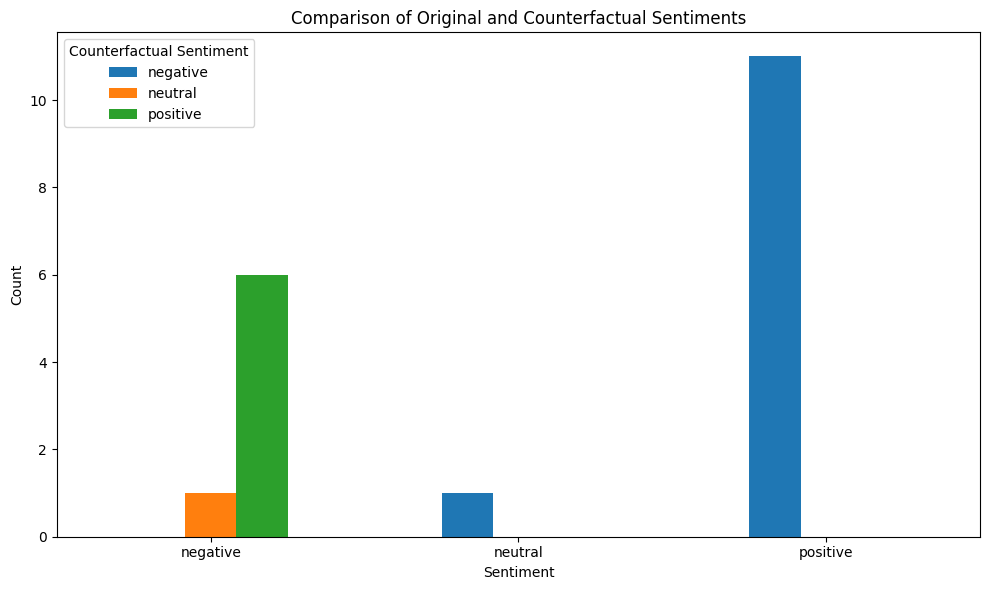

In [10]:
# Example usage with the complete reviews
reviews = [
    "آش دوغ ترش نبود و آش شله قلمکار اصلا کیفیت مناسبی نداشت. پر از آرد و حبوبات نپخته خیلی بد مزه بود و خیلی شیرین بود",
    "مثل همیشه خوب و باکیفیت. هر وقت هم که داخل قسمت توضیحات چیزی خواستیم انجام دادن، در حالی که خیلی جاها اصلا توجه به توضیحات نمیکنن.",
    "غذا خوب بود ولی قیمت غذا و قیمت ارسال کمی زیاده.",
    "جوجه کباب خیلی خوشمزه و ترد بود و اصلا خشک یا سوخته نبود، برنج هم به خوبی دم کشیده بود و تهدیگ مناسبی داشت فقط حجم برنج می‌توانست بیشتر باشد، هزینه حمل ٥ تومنی از دولت تا پل صدر کمی زیاد است لطفا در این مورد تجدید نظر نمایید، بسته بندی هم خوب بود غذا گرم رسید",
    "غذای جوجه برنجش شفته شده بود",
    "نان خامه‌ای خوب تخمه خیلی تازه نبود",
    "چرا به کل سفارش مالیات بر ارزش افزوده اضافه میشه",
    "کیفیت نسبتا خوب ولی حجم مرغ سوخاری ۲ تکه آن ۲ تکه نبود و عملا یک تکه و نیم بود یک تکه سینه و یک تکه کتف",
    "سرعت و کیفیت ارسال بالا",
    "لطفا موجود کن دیجی",
    "من این لپتاپو برای کارای روزمره ی برادرم گرفتم و ویندوز 10 روز نصب کردم تا الان خیلی عالی جواب میده و خیلی خوبه اگه برای کارای روزمره میخواین من واقعا این لپتاپو بهتون پیشنهاد میکنم  اولش به خاطر امتیاز پایینی که دوستان داده بودن مردد بودم  ولی بالاخره گرفتم و فهمیدم که امتیازش واقعا بالا تر از این حرفا باید باشه",
    "این لب تاپ واقعا نسبت به قیمتش به صرفس حتما پیشنهاد میکنم به کسایی که با قیمت کم ویژگی های بالایی میخوان حتما بهش فکرکنن",
    "من امروز به دستم رسید  یه نکته که هست اینه که این لپ تاپ 2 تا کارت گرافیک داره یه اینتل 5500 و یه amd 2g اینو من تو دیجیکالا ندیدم  نسبت به عکس خیلی زیبا تر و شیک تره  کیفیت ساختش خوبه  صداش برای یه لپ تاپ خوبه زیاد نیست ولی قابل قبوله اگه پورت vga احتیاج ندارین واقعا یه چیز اضافیه نباشه بهتره  تو این رنج قیمت مناسبه  داغ نمیکنه البته من هنوز باهاش کاره خاصی انجام ندادم  ال سی دی شفاف مشکلات خودشو داره ولی واسه این لپ تاپ خوبه  اگه یه لپ تاپه زیبا و ساده میخواید که کارای معمولی باهاش انجام بدین شک نکنین پشیمون نمیشین ولی برا بازی پیشنهاد نمیکنم ممنون بابت ارسال سر وقت از دیجی کالا",
    "بسیاردستگاه عالی و زیبا و کار آمدی هست",
    "عالیه  من راضى بودم",
    "سلام  با این تخفیفی که داده و این قیمت به نظرم خیلی خوبه و می ارزه  ممنون از دیجی کالا  خیلی کرم پودر سبکو خوبیه ولی زود تموم میشه  Flower perfection بورژوا خیلی پوشش دهیش بهتره",
    "با توجه به مزایای این نوع پنکه خصوصا ثبات و کم صدا بودنش تو دور تندو بازدهی بالا  و ایرانی بودن محصول   برای کسانی که با پنکه با پایه بلند نیازی ندارند پیشنهاد میکنم",
    "من این لپ تاپ رو چند ماه پیش خریدم و الان خیلی ناراحتم هم صداش کمه هم شارژش زود تموم میشه  دی وی دی اکسترنالشم بعد از دو بار استفاده دیگه درش بسته نشد وقتی هم درش و خودم نگه دارم هم درست کار نمیکنه  پیشنهاد نمیکنم  قیمتش هم تقریبا زیاد بود انتظار لپ تاپ خیلی خوبی رو داشتم ولی",
    "سلام دوستان حدود 2 سالی هست که این گوشی رو دارم و باید بگم فوق العادست فقط از اون اول مشکل باتری داشتم تا الان که دیگه عمر باتریش تموم شده و باید تعویض بشه اگه استفادتون از گوشی کمه حتما پیشنهاد میکنم این گوشی رو و اگه مثه من همیشه گوشی دستتون هست باید بگم که اصلا انتخاب مناسبی نیست چون همه نقاط قوت این گوشی با روشن بودنش قابل استفادست در غیر این صورت هیچ  و در آخر یادم رفت بگم که زیبایی خاصی هم داره که خیلی ها با آیفون اشتباه میگیرنش"
]

# Initialize a list to store results
results = []

# Process each review and save results
for review in reviews:
    sentiment = make_request_with_retry(get_sentiment, review)
    time.sleep(10)
    extractive_phrase = make_request_with_retry(get_extractive_self_explanation, review)
    time.sleep(10)
    counterfactual = make_request_with_retry(get_counterfactual_review, review)
    time.sleep(10)
    counterfactual_sentiment = make_request_with_retry(get_sentiment, counterfactual)

    print(f"Review: {review}")
    print(f"Sentiment: {sentiment}")
    print(f"Most Important Phrase: {extractive_phrase}")
    print(f"Counterfactual Review: {counterfactual}")
    print(f"Counterfactual Sentiment: {counterfactual_sentiment}")
    print("-" * 80)

    # Store the results in a dictionary
    result = {
        "Original Review": review,
        "Original Sentiment": sentiment,
        "Most Important Phrase": extractive_phrase,
        "Counterfactual Review": counterfactual,
        "Counterfactual Sentiment": counterfactual_sentiment
    }
    
    # Append the result to the list
    results.append(result)
    
    # Wait between requests to avoid rate limits
    #time.sleep(10)

# Convert the list of results into a DataFrame
df = pd.DataFrame(results)

# Save the results to a CSV file
df.to_csv("sentiment_analysis_results.csv", index=False)

# Plotting the comparison
fig, ax = plt.subplots(figsize=(10, 6))
df[['Original Sentiment', 'Counterfactual Sentiment']].value_counts().unstack().plot(kind='bar', ax=ax)
plt.title("Comparison of Original and Counterfactual Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

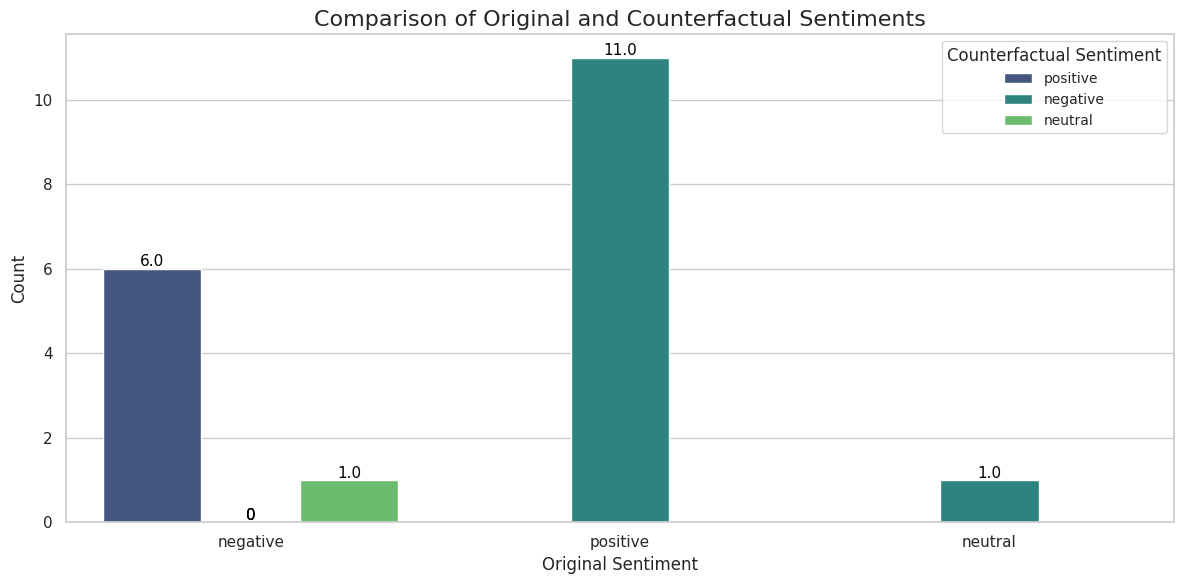

In [12]:
# Create a bar plot with better aesthetics
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the count plot
ax = sns.countplot(data=df, x='Original Sentiment', hue='Counterfactual Sentiment', palette='viridis')

# Add title and labels
plt.title("Comparison of Original and Counterfactual Sentiments", fontsize=16)
plt.xlabel("Original Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Display counts on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Adjust legend position
plt.legend(title='Counterfactual Sentiment', loc='upper right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


### Observations:
1. **Original Sentiment "negative"**:
   - There were **6** instances where the original sentiment was "negative," and the counterfactual sentiment turned "positive" (dark blue bar).
   - There were **1** instance where the original sentiment was "negative," and the counterfactual sentiment remained "neutral" (light green bar).
   - No instances of the counterfactual sentiment being "negative."

2. **Original Sentiment "neutral"**:
   - There was **1** instance where the original sentiment was "neutral," and the counterfactual sentiment changed to "negative" (teal bar).
   - No other instances of counterfactual sentiments in this category.

3. **Original Sentiment "positive"**:
   - There were **11** instances where the original sentiment was "positive," and the counterfactual sentiment changed to "negative" (teal bar).
   - No instances of counterfactual sentiment being "positive" or "neutral" when the original sentiment was "positive."


# Load Results and calculate `metrics`

In [18]:
# Load the dataset from the CSV file
df = pd.read_csv('sentiment_analysis_results.csv')

# Display the first few rows of the dataframe
df

,Original Review,Original Sentiment,Most Important Phrase,Counterfactual Review,Counterfactual Sentiment
0,آش دوغ ترش نبود و آش شله قلمکار اصلا کیفیت منا...,negative,"""آش شله قلمکار اصلا کیفیت مناسبی نداشت. پر از آرد",آش دوغ ترش و خوشمزه بود و آش شله قلمکار کیفیت ...,positive
1,مثل همیشه خوب و باکیفیت. هر وقت هم که داخل قسم...,positive,مثل همیشه خوب و باکیفیت,مثل همیشه بد و بی‌کیفیت. هر وقت هم که داخل قسم...,negative
2,غذا خوب بود ولی قیمت غذا و قیمت ارسال کمی زیاده.,negative,"""قیمت غذا و قیمت ارسال کمی زیاده""",غذا عالی بود و ارزش قیمت و هزینه ارسال را داشت.,positive
3,جوجه کباب خیلی خوشمزه و ترد بود و اصلا خشک یا ...,positive,جوجه کباب خیلی خوشمزه و ترد بود و اصلا خشک یا ...,جوجه کباب خیلی بد مزه و سفت بود و کاملا خشک و ...,negative
4,غذای جوجه برنجش شفته شده بود,negative,"""برنجش شفته شده بود""","""غذای جوجه برنجش عالی و کاملا پخته شده بود""",positive
5,نان خامه‌ای خوب تخمه خیلی تازه نبود,negative,"""تخمه خیلی تازه نبود""",نان خامه‌ای خوب و تخمه خیلی تازه بود,positive
6,چرا به کل سفارش مالیات بر ارزش افزوده اضافه میشه,negative,"""مالیات بر ارزش افزوده""","""چرا مالیات بر ارزش افزوده به کل سفارش اضافه ن...",neutral
7,کیفیت نسبتا خوب ولی حجم مرغ سوخاری ۲ تکه آن ۲ ...,negative,عملا یک تکه و نیم بود,کیفیت نسبتاً ضعیف، اما حجم مرغ سوخاری ۲ تکه آن...,positive
8,سرعت و کیفیت ارسال بالا,positive,"""سرعت و کیفیت ارسال بالا""",سرعت و کیفیت ارسال پایین,negative
9,لطفا موجود کن دیجی,neutral,"""لطفا موجود کن""","""لطفا موجود نکن دیجی""",negative


In [19]:
# Extract the original and counterfactual sentiments
y_true = df['Original Sentiment']
y_pred = df['Counterfactual Sentiment']

# Calculate the classification metrics
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df

,precision,recall,f1-score,support
negative,0.0,0.0,0.0,7.0
neutral,0.0,0.0,0.0,1.0
positive,0.0,0.0,0.0,11.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,19.0
weighted avg,0.0,0.0,0.0,19.0


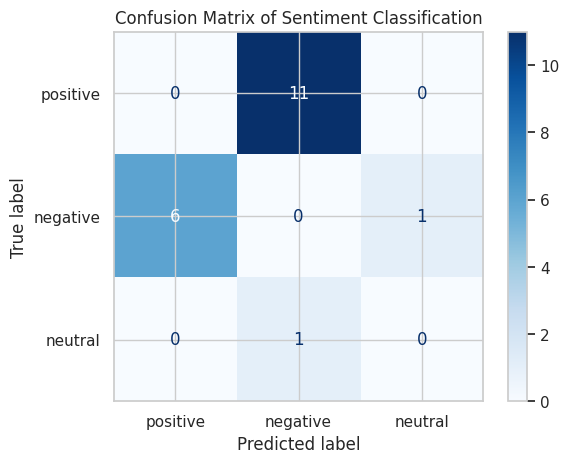

KeyError: "None of [Index(['precision', 'recall', 'f1-score'], dtype='object')] are in the [index]"

In [20]:
# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative', 'neutral'])

# Plotting the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Sentiment Classification")
plt.show()

# Filter the classification report to only include precision, recall, and f1-score
metrics = report_df.loc[['precision', 'recall', 'f1-score'], ['positive', 'negative', 'neutral']]

# Plot the metrics
metrics.T.plot(kind='bar', figsize=(10, 6))
plt.title("Classification Metrics by Sentiment")
plt.ylabel("Score")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()